
# Group B - Counter Strike GO round winner classification

Authors: ALBIN S., CKALIB N., DANIEL R., JORGE ANDRÉS R., NICOLAS G., TOMÁS F.

Data source: https://www.kaggle.com/christianlillelund/csgo-round-winner-classification

Last revision: 13/September/2020

<img src="./images/CounterStrikeGO.jpg" align="center">

# Introduction

We're putting in practice what we need to know about feature engineering and model validation.

CS:GO is a tactical shooter, where two teams (CT and Terrorist) play for a best of 30 rounds, with each round being 1 minute and 55 seconds. There are 5 players on each team (10 in total) and the first team to reach 16 rounds wins the game. At the start, one team plays as CT and the other as Terrorist. After 15 rounds played, the teams swap side. There are 7 different maps a game can be played on. You win a round as Terrorist by either planting the bomb and making sure it explodes, or by eliminating the other team. You win a round as CT by either eliminating the other team, or by disarming the bomb, should it have been planted.

Learn more about CS:GO: https://en.wikipedia.org/wiki/Counter-Strike:_Global_Offensive

The dataset consists of ~700 demos from high level tournament play in 2019 and 2020. Warmup rounds and restarts have been filtered, and for the remaining live rounds a round snapshot have been recorded every 20 seconds until the round is decided. The target variable is the one called `round_winner`, taking the values `CT` for Counter-Terrorist or `T` for Terrorist.

## Steps to be followed <font color=red>[CAN BE REMOVED ONCE WE FINISH]</font>

1. Read the dataset
2. Data preparation: Check for variable types, NAs, values imputation, column names, scaling, encoding, etc.
3. EDA (Exploratory Data Analysis): Try to extract some insights from the data like features completely uncorrelated or under-represented. Can we merge values from any of the categorical features? Would it be beneficial to discretize numerical features? Do we have outliers?
3. Baseline: Simply take the simpler possible model (logistic regression) and set a base score that we'll try to improve along the process. To run logistic regression **you need** to have **numerical features**, so the fastest way of preparing your data to be used in `lr` is to perform _one hot encoding_. Perform this encoding so that you don't destroy the original prepared data. Consider to include onehot encoding as an step which is done right before evaluation over a copy of your prepared data.
4. Feature Engineering: We will try
    - categorical encoding: compare techniques like onehot and target encoding
    - feature selection: compare the results from filtering, wrappers and regularization
    - feature construction: compare GPLearn with _ad hoc_ methods, or Deep Feature Synthesis.
5. Evaluation: the goal here is to fine tune our models, so, to do that we need a new model, like **decission trees**, in this case. We will experiment with:
    - Cross validation and bootstrapping comparison.
    - Fine tune tree parameters: pruning and parameters optimization.

# Read the dataset

In [2]:
# import libraries numpy, pandas, and scipy.stats module
import numpy as np
import pandas as pd
import scipy.stats as stats
import math
import matplotlib.pyplot as plt

In [3]:
# import dataset using pd.read_csv() function
data = pd.read_csv("csgo_round_snapshots.csv")

FileNotFoundError: [Errno 2] File csgo_round_snapshots.csv does not exist: 'csgo_round_snapshots.csv'

Check imports needed and place all at the top of the notebook.

In [2]:
import category_encoders as ce

from sklearn import tree
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import RFE
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.utils import resample
from sklearn_pandas import CategoricalImputer

C:\Users\drodriguez45\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [9]:
data

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122405,15.41,11.0,14.0,de_train,True,200.0,242.0,195.0,359.0,100.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0
122406,174.93,11.0,15.0,de_train,False,500.0,500.0,95.0,175.0,11500.0,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
122407,114.93,11.0,15.0,de_train,False,500.0,500.0,495.0,475.0,1200.0,...,4.0,3.0,5.0,1.0,0.0,0.0,5.0,0.0,0.0,0
122408,94.93,11.0,15.0,de_train,False,500.0,500.0,495.0,475.0,1200.0,...,5.0,0.0,3.0,0.0,0.0,0.0,4.0,0.0,0.0,0


In [8]:
# Our target feature is 'round_winner', replace the labels
# 'CT' and 'T' in the data for '1' and '0'
target = 'round_winner'
data[target] = data[target].replace({'CT': 1, 'T':0})

# Data Preparation <font color=red>ALBIN AND JORGE</font>

Check for NA, not relevant variables, outliers, scale numerical variables

In [15]:
data.head(10)

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
0,175.00,0.0,0.0,de_dust2,False,500.0,500.0,0.0,0.0,4000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
1,156.03,0.0,0.0,de_dust2,False,500.0,500.0,400.0,300.0,600.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
2,96.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
3,76.03,0.0,0.0,de_dust2,False,391.0,400.0,294.0,200.0,750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
4,174.97,1.0,0.0,de_dust2,False,500.0,500.0,192.0,0.0,18350.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
5,114.97,1.0,0.0,de_dust2,False,500.0,500.0,500.0,0.0,1750.0,...,0.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,CT
6,94.97,1.0,0.0,de_dust2,False,295.0,111.0,296.0,0.0,1700.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
7,74.97,1.0,0.0,de_dust2,False,295.0,111.0,296.0,0.0,1700.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
8,54.97,1.0,0.0,de_dust2,False,249.0,89.0,269.0,0.0,2300.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT
9,174.97,2.0,0.0,de_dust2,False,500.0,500.0,196.0,0.0,19800.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CT


WHAT to do with NA's. Then, scale numerical variables, and finally check if all categorical variables are correctly encoded.

In [14]:
# Get the number of NAs per feature
num_nas = []
for feature in df.columns:
    num_nas.append(df[feature].isna().sum())
print(f'{len(df.columns)} features have a median of {math.floor(np.median(num_nas))} NAs')

97 features have a median of 0 NAs


In [ ]:
#Check for outliers

## Imputation and Scaling <font color=red>Imputation is not needed as it seems we have no NA</font>

There are [several ways of imputing missing values](https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation). I'd like to use a multivariate approach, which is much better than univariate methods (imputing by the mean, etc.). To do so, I will use the methods available in `scikit-learn` library ([here](https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation)).

<font color=red>Could be a good idea to split categorical and numerical features to work separately on them</font>

In [8]:
num_imputer = IterativeImputer(max_iter=10, random_state=0)
num_feats = num_imputer.fit_transform(data.features[data.numerical_features].values)

To perform imputaton on categorical variables, I decided to use a method provided by the library `sklearn_pandas` that implements a `CategoricalImputer`.

In [9]:
cat_imputer = CategoricalImputer()
df = pd.DataFrame()
for col in data.categorical_features_na:
    df[col] = cat_imputer.fit_transform(data.features[col].values)
ds = Dataset.from_dataframe(df)

Finally, the result of imputing both: numerical and categorical, is now merged together in a single Dataset (or you can also use a dataframe, if you prefer).

In [10]:
ds.add_columns(data.target)
ds.set_target('band_type')

# add the resulting imputed numerical features to the categorical imputed
ds.add_columns(pd.DataFrame(num_feats, columns=data.numerical_features));

Scale all the numeric values, at this point.

In [11]:
#Scale numeric variables

Now, my dataset is ready to be analyzed. Lots of categorical and numerical variables.

# EDA <font color=red>NICOLAS AND DANIEL</font>



In [20]:
df.describe(include = 'all')

,time_left,ct_score,t_score,map,bomb_planted,ct_health,t_health,ct_armor,t_armor,ct_money,...,t_grenade_flashbang,ct_grenade_smokegrenade,t_grenade_smokegrenade,ct_grenade_incendiarygrenade,t_grenade_incendiarygrenade,ct_grenade_molotovgrenade,t_grenade_molotovgrenade,ct_grenade_decoygrenade,t_grenade_decoygrenade,round_winner
count,122410.000000,122410.000000,122410.000000,122410,122410,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,...,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410.000000,122410
unique,NaN,NaN,NaN,8,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,de_inferno,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,T
freq,NaN,NaN,NaN,23811,108726,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62406
mean,97.886922,6.709239,6.780435,NaN,NaN,412.106568,402.714500,314.142121,298.444670,9789.023773,...,1.858100,1.540814,1.627146,1.001969,0.019819,0.048011,1.352095,0.027694,0.025750,NaN
std,54.465238,4.790362,4.823543,NaN,NaN,132.293290,139.919033,171.029736,174.576545,11215.042286,...,1.794473,1.737804,1.829147,1.458084,0.143933,0.227669,1.663246,0.169531,0.164162,NaN
min,0.010000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,54.920000,3.000000,3.000000,NaN,NaN,350.000000,322.000000,194.000000,174.000000,1300.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,94.910000,6.000000,6.000000,NaN,NaN,500.000000,500.000000,377.000000,334.000000,5500.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,NaN
75%,166.917500,10.000000,10.000000,NaN,NaN,500.000000,500.000000,486.000000,468.000000,14600.000000,...,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,NaN


In [1]:
df.head()

NameError: name 'df' is not defined

I also want to know how may samples belong to the class '1' and how many to class '0', simply to check if the data set is balanced (you can see that YES, it is).

In [10]:
data[target].value_counts()

0    62406
1    60004
Name: round_winner, dtype: int64

Starting by knowing if there're underrepresented features: this is, values that are only present in a very small portion of the samples. 

In [14]:
#code 

['proof_on_ctd', 'blade_mfg', 'direct_steam', 'solvent_type']


Let's see what's the situation in the categories of those clases. I will simply count the number of unique values present at each of those columns (above):

In [15]:
for col in under_repr:
    print(col)
    res = data[col].value_counts()
    print(f'{res}\n----')

proof_on_ctd
YES    517
NO      22
Name: proof_on_ctd, dtype: int64
----
blade_mfg
BENTON      538
UDDEHOLM      1
Name: blade_mfg, dtype: int64
----
direct_steam
NO     524
no      13
YES      2
Name: direct_steam, dtype: int64
----
solvent_type
LINE      522
XYLOL      15
NAPTHA      2
Name: solvent_type, dtype: int64
----


From that result, we will remove those features, as they are not very informative (a priori). You can also combine them into a single feature by merging the four of them.

In [16]:
#Merge categories if needed

Let's take a look at the histograms of the numerical values.

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

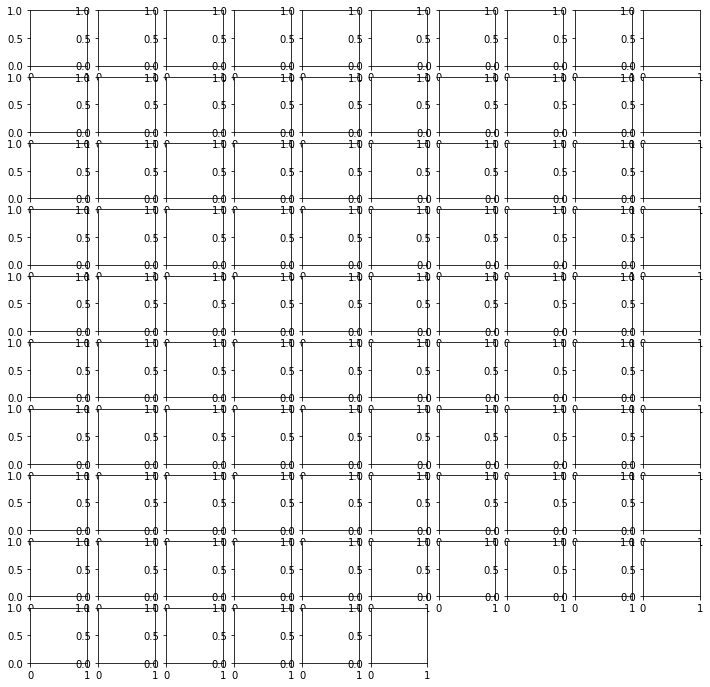

In [19]:
%matplotlib inline
import matplotlib.pylab as plt
attribute_columns = list(data.columns)
if True:
    fontsize = 10
    fig = data[attribute_columns].hist(bins = 20, figsize = (12, 12),
                                       xlabelsize=fontsize,
                                       ylabelsize=fontsize)
    for x in fig.ravel():
        x.title.set_size(fontsize)
else:
    nrows = (len(attribute_columns)+1) // 2
    plt.figure(figsize=(12,25))
    for i in range(len(attribute_columns)):
        name = attribute_columns[i]
        plt.subplot(nrows,2,i+1)
        data[name].hist()
        plt.title(name, fontsize=14)
    
plt.show()

There are several interesting plots we can show, build the code to get some like the following:
<font color=red>Build the code</font>

<img src="./images/map_winner.JPG" align="center">
<img src="./images/defuse_winner.JPG" align="center">
<img src="./images/bomb_winner.JPG" align="center">

# Baseline <font color=red>CKALIB AND TOMAS</font>

As the CS:GO Kaggle competition is now closed, so we must evaluate your results using an alternative method. All the teams will have to include this snippet of code in order to read the data, and split it into training and validation sets.

In [6]:
from sklearn.model_selection import train_test_split

target = 'round_winner'
features = [column for column in data.columns if column != target]

X, X_val, y, y_val = train_test_split(
    data[features],
    data[target],
    test_size=0.3,
    random_state=1,
    stratify=data[target])

print(X.shape)
print(X_val.shape)
print(y.shape)
print(y_val.shape)

(85687, 96)
(36723, 96)
(85687,)
(36723,)


Remember that the validation set will be used to obtain the FINAL score of your model, not the intermediate validation scores that will help you to determine whether your model is overfitting. So, you will need to further split your data (X and y) sets into training and test.

I will build a method to evaluate a basic logistic regression over a split of the data set using cross validation.

The method requires that you send it the independent variables (X) and the dependent variables (y) as a pandas DataFrame. We can access the dataframe inside the `Dataset` by calling, either, `.features` or `.target`.

In [21]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, matthews_corrcoef

def evaluate_LogReg(X: pd.DataFrame, y: pd.DataFrame,
                    metric: str='F1',
                    seed: int=123,
                    printout: bool=False):
    """
    Fits a logistic regression with the training set, and evaluates it with 
    the test set, using Accuracy, F1, Recall or MCC metrics.

    Params
      X: A Pandas DataFrame with all the values to be used to fit the logit
      y: The dependent variable.
      metric: The metric to be returned
      printout: True/False indicating whether you want to print results

    """
    # Split the data is the first thing to do
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2)

    lr = LogisticRegression().fit(X_train, y_train)
    y_hat = lr.predict(X_test)

    accuracy = accuracy_score(y_test, y_hat)
    F1 = f1_score(y_test, y_hat)
    recall = recall_score(y_test, y_hat)
    MCC = matthews_corrcoef(y_test, y_hat)
    
    if printout is True:
        print('Accuracy:', accuracy)
        print('F1:', F1)
        print('Recall:', recall)
        print('MCC:', MCC)
    
    return eval(metric)

Let's run the **baseline**. We will simply call our method with the numerical features only, simply to see what is the expected F1 metric. Ideally, we should call the evaluation method with all our features, but to do so, we must convert our categorical features into numbers. For baselining, we can start by simply applying a **onehot** encoding to them to see what is the result.

# Baseline with numerical features only

To start with, let's simply use numericals:

In [22]:
evaluate_LogReg(data.numerical, data.target)

0.6024096385542168

Now, we will try to onehot our categoricals to apply the LogisticRegression to all our features. We will use a copy of the dataset since we do not want to premanently encode our data with that scheme.

# Basline with all features (onehot)

I will use Dataset method `onehot_encode` but you can use Pandas `get_dummies` or the one provided by `scikit learn`.

as you can see, the result is a Dataset with 30 numerical variables, instead of the original combination of 21 numericals + 4 categoricals.

In [23]:
# Get a copy of data
from copy import deepcopy
data_copy = deepcopy(data)

# Onehot
data_copy.onehot_encode()
data_copy.describe()

29 Features. 539 Samples
Available types: [dtype('float64')]
  · 0 categorical features
  · 29 numerical features
  · 0 categorical features with NAs
  · 0 numerical features with NAs
  · 30 Complete features
--
Target: band_type (int64)
'band_type'
  · Min.: 0.0000
  · 1stQ: 0.0000
  · Med.: 0.0000
  · Mean: 0.4212
  · 3rdQ: 1.0000
  · Max.: 1.0000


In [24]:
# Call the evaluation method with all data in the Dataset.
evaluate_LogReg(data_copy.features, data_copy.target)

0.5476190476190476

It seems that adding the categorical features produces a different result. However, if you remember the rules of Logit we must avoid co-linearity, variables which are not completely independent or even not normal distributions.

We will simplify later on the evaluation by using a simpler model.

## Problems with this baseline

However, we cannot evaluate a model like I proposed before. To demostrate what is the problem, I will call the same method 100 times, storing its result each time in a list, to later plot it.

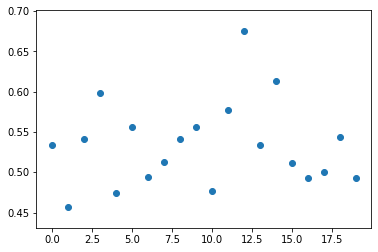

In [25]:
my_list = []
for _ in range(20):
    result = evaluate_LogReg(data_copy.features, data_copy.target)
    my_list.append(result)
plt.scatter(range(20), my_list)

We've obtained 100 different values for the evaluation of the baseline. Which one is the good one? The highest value? The lowest? The average? The median? ....

None of them... this plot simply illustrates that if you split your dataset 100 times, you train your model with different portions of the data 100 times, producing 100 different results.

To avoid this _variance_ in results, we want to estimate what will be the expected result in test. To achieve that we use **cross validation**. The idea is to split the data a number of times but use the average test score obtained from all of them as a reasonable estimation of what to expect from this model.

## Cross Validation 

To evaluate our model in a slightly simpler way, let's use this method: `cv_classification`. It accepts a Dataset as input, and an `estimator`, which is simply the model I want to use.

Internally, it will repeat a number of times (`num_iterations`) the following steps:

  1. Randomly split the data set into training and test
  2. Fit the estimator with the training portion of the data
  3. Obtain a CV metric in training for this model
  4. Obtain a metric in test for the predictions obtained with the model just fitted in step 2
  5. Save the scores in an array to later return all of them

In [26]:
def cv_classification(my_dataset, estimator, num_iterations=20, verbose=True):
    train_scores=[]
    test_scores=[]
    for i in range(num_iterations):
        X, y = my_dataset.split(seed=23*i ^ 2)

        # We want to call a method whose name is the argument to this func.
        estimator.fit(X.train, y.train)
        train_metric = cross_val_score(estimator, X.train, y.train, scoring='f1')
        train_scores.append(np.median(train_metric))

        test_score = f1_score(y.test, estimator.predict(X.test))
        test_scores.append(test_score)

    if verbose:
        print('Training median F1: {:.4f} +/- {:.2f}%'.format(
            np.median(train_scores), np.std(train_scores)*100.))
        print('Test F1: {:.4f} +/- {:.2f}%'.format(
            np.median(test_scores), np.std(test_scores)*100.))

    return train_scores, test_scores

So, if we decide to use the method above to score our Linear Regression model using cross validation (20 iterations), what we have to do is the following:

In [27]:
lr = LogisticRegression()
train_lr_scores, test_lr_scores = cv_classification(data_copy, lr)

Training median F1: 0.5572 +/- 3.26%
Test F1: 0.5485 +/- 4.26%


The interpretation from these training and test scores is the following:

* Our model, in training, is capable of achieving a 56.17% F1 score, with a variance of 3.1%. This is useful to check if our training is getting very high results (overfitting) or very high variance (data contains too much noise).
* Our model is expected to throw a F1 of 54% (+/- 4.5%) when predicting over unseen data.
* Since performance test is a bit below training performance, that means that we're not overfitting, and that our model is generalizing correctly. If test performance were better than training performance, that's an indication that your training can be improved by tuning a bit more your parameters (too much bias).



## Baseline with decision tree

To make things a bit simpler in our baseline, we will use a decision tree. Spending too much time cleaning our data to fit normal distributions and finding co-linearity could not be worthy in the end. So, let's try to produce a quick baseline with a single decision tree.

In [28]:
baseline_tree = DecisionTreeClassifier(random_state=123)
base_train, base_test = cv_classification(data_copy, baseline_tree)

Training median F1: 0.6250 +/- 2.57%
Test F1: 0.6262 +/- 5.86%


# Feature Engineering

We'll try a conservative approach in our feature engineering process. Instead of playing too much attention to filtering, we'll try only find highly correlated features, to focus on creating new features.

I'm using the original `data`. I will discard the onehot version, as I want to play with the original features to later perform the best possible encoding (not only onehot encoding).

## Catboost encoding vs. Target encoding

We're going to compare what is the effect of encoding with Catboost or Target encoding vs. the onehot encoded proposed above for the baseline.

In [29]:
# Uncomment this line if you haven't installed caatboos (categorical_encoders) already
# !pip install catboost

Simple `fit_transform` our data using the proposed encoder, and then:
  - we create another dataset (since we don't want to destroy the original one)
  - we add the new numerically encoded features proposed by Catboost
  - we remove the old categorical features

In [30]:
# Create the Catboost encoder, and "fit" + "transform" our data.
catboost_enc = ce.CatBoostEncoder(cols=data.categorical_features)
new_columns = catboost_enc.fit_transform(
    data.categorical, data.target).add_suffix('_cb')

# Create another Dataset with my original features
data_cb = Dataset.from_dataframe(data.all)
data_cb.set_target('band_type')
# ... and I add the newly encoded columns, removing the categorical ones.
data_cb.add_columns(new_columns).drop_columns(data_cb.categorical_features);

Now, train a decission tree classifier with the new data to see if we're improving a bit.

In [31]:
catboost_tree = DecisionTreeClassifier(random_state=666)
cb_train, cb_test = cv_classification(data_cb, catboost_tree)

Training median F1: 0.6431 +/- 2.76%
Test F1: 0.6454 +/- 5.90%


Now it's time to try the TargetEncoder. Same steps as above

In [32]:
# Create the Catboost encoder, and "fit" + "transform" our data.
target_enc = ce.TargetEncoder(cols=data.categorical_features)
new_columns = target_enc.fit_transform(
    data.categorical, data.target).add_suffix('_tg')

# Create another Dataset with my original features
data_tg = Dataset.from_dataframe(data.all)
data_tg.set_target('band_type')
# ... and I add the newly encoded columns, removing the categorical ones.
data_tg.add_columns(new_columns).drop_columns(data_tg.categorical_features);

In [33]:
target_tree = DecisionTreeClassifier(random_state=666)
tg_train, tg_test = cv_classification(data_tg, target_tree)

Training median F1: 0.6194 +/- 2.76%
Test F1: 0.6304 +/- 6.90%


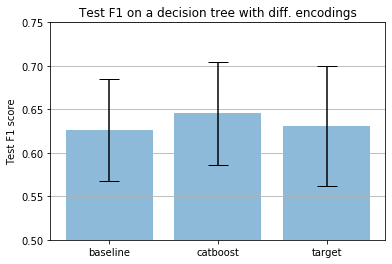

In [34]:
# Plot the three results obtained so far.
x_pos = range(3)
fig, ax = plt.subplots()
ax.bar(x_pos, 
       [np.median(base_test), np.median(cb_test), np.median(tg_test)], 
       yerr=[np.std(base_test), np.std(cb_test), np.std(tg_test)], 
       align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Test F1 score')
ax.set_xticks(x_pos)
ax.set_xticklabels(['baseline','catboost','target'])
ax.set_ylim([0.50, 0.75])
ax.set_title('Test F1 on a decision tree with diff. encodings')
ax.yaxis.grid(True)

We can see, that there's no big difference but, a priori, this experiment suggests that catboost encoding is giving us some advantage.

We will keep that dataset (without categorical variables, to continue deciding on how to move forward.

In [35]:
data = Dataset.from_dataframe(data_cb.all)
data.set_target('band_type');

## Next: Feature Selection

We cannot explore deep feature synthesis, as it is required a lot of knowledge about the problem domain that we don't have for this dataset. GPlearn is a good alternative, but let's filter out some attributes that might be too much correlated or not leading to good performance.

### Filtering

When plotting the covariance matrix we can see a candidate group of features that might present high correlation and could be discarded using wrapper methods (blade_pressure, was, varnish_pct, paper_mill_local_cb, proof_cut, roller_durometer and grain_screen_cb).

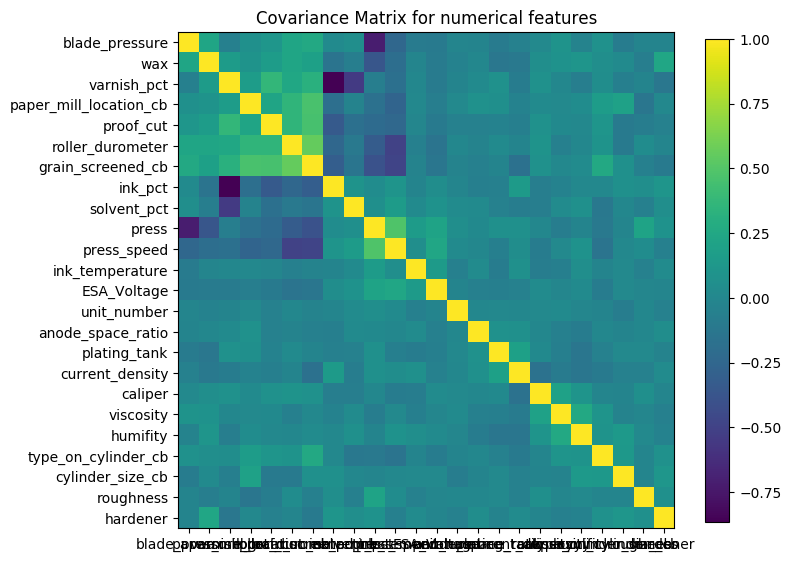

In [36]:
data.plot_covariance()

Any filtering decision should be based on a relevant gain in our model. So, the steps to be followed must be:
  1. select features to be removed
  2. evaluate model without them
  3. if new performance (in test) is better, then continue
  4. otherwise, keep the features.
  
### Recursive Feature Elimination

Let's start by using Recursive Feature Elimination from sklearn. It's a sophisticated implementation of stepwise selection, but with recursive decisions instead of single-step decisions. The parameters we need to have in order to use it are:
  - A model –our decision tree, in our case
  - The number of features we want to be finally selected
  - The `step` which is the nr. of features to be removed at each iteration.

In [37]:
# A function that calls RFE and returns the best features found
def rfe(data, num_features):
    estimator = DecisionTreeClassifier(random_state=123)
    selector = RFE(estimator, num_features, step=1)
    selector = selector.fit(data.features, data.target)
    return selector.support_

This piece of code will evaluate a range of possible subsets of features, from 5 to all features included. At each iteration, it will keep the test score to later plot it, and see what is the best strategy to choose.

In [38]:
# Loop over the range of features in our dataset and capture results.
rfe_test_scores = pd.DataFrame()
min_range = 5
max_range = len(data.feature_names)
rfe_tree = DecisionTreeClassifier(random_state=666)

# This is a loop over all possible values I want to evaluate
for num_features in range(min_range, max_range):
    # Obtain the best features
    best_features = rfe(data, num_features)
    # Build a new dataset ONLY with best features selected.
    data_rfe = Dataset.from_dataframe(
        pd.concat(
            [data.features[data.features.columns[best_features]], data.target], axis=1
        )
    )
    data_rfe.set_target('band_type')

    # Evaluate (CV) what is the F1 of this dataset
    _, test_f1 = cv_classification(data_rfe, rfe_tree, verbose=False)
    
    # Keep results to later plot them
    rfe_test_scores = rfe_test_scores.append(pd.Series(test_f1), ignore_index=True)
    del(data_rfe)

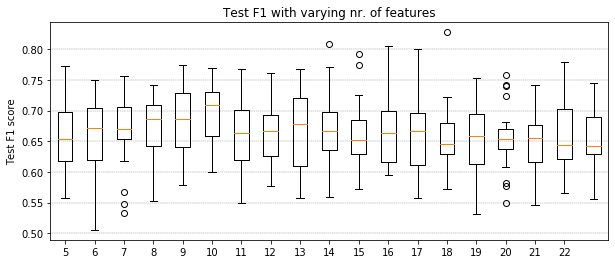

In [39]:
x_pos = range(min_range, max_range)

fig, ax = plt.subplots(figsize=(10,4))
ax.boxplot(rfe_test_scores)
ax.set_ylabel('Test F1 score')
ax.set_xticks(range(1, len(x_pos)))
ax.set_xticklabels(x_pos)
# ax.set_ylim([0.50, 0.75])
ax.set_title('Test F1 with varying nr. of features')
ax.yaxis.grid(True, color="gray", linestyle='--', linewidth=0.4)

From my experiment, 10 features is the best option. It also presents a not very high variance. So, now I call RFE asking it to return me 10 features and continue.

In [40]:
best_features = rfe(data, 10)
data_rfe = Dataset.from_dataframe(
    pd.concat(
        [data.features[data.features.columns[best_features]], data.target], axis=1
    )
)
data_rfe.set_target('band_type')
data_rfe.features.head()

,press,proof_cut,viscosity,press_speed,ink_pct,ESA_Voltage,anode_space_ratio,grain_screened_cb,cylinder_size_cb,paper_mill_location_cb
0,0.445926,1.164528,-0.616524,-0.375882,-0.978145,-0.561603,0.395149,0.421150,0.421150,0.421150
1,0.445926,1.164528,-0.616524,0.234430,-0.142550,-0.561603,0.395149,0.710575,0.710575,0.710575
2,-0.360181,1.978825,-1.365045,0.081852,-0.351449,-0.561603,0.167955,0.473717,0.473717,0.473717
3,-0.225830,0.815543,-1.365045,-1.086896,-0.009615,-0.561603,1.010383,0.355288,0.355288,0.355288
4,-0.225830,0.582887,-0.616524,0.844741,0.351210,1.580503,0.730914,0.421150,0.284230,0.284230


Check that this selection keeps the performance observed in the previous experiment.

In [41]:
rfe_train, rfe_test = cv_classification(data_rfe, rfe_tree)

Training median F1: 0.6667 +/- 3.13%
Test F1: 0.7085 +/- 5.09%


In [42]:
data = Dataset.from_dataframe(data_rfe.all)
data.set_target('band_type');

### Exercise

Compare the results obtained using RFE with Relief algorithm or stepwise selection.

# Evaluation and Validation

We have 10 features, and out results are much better than those obtained in the baseline. What's next then? 

First topic to explore is how to reduce the variance in test, since we've a large number as a result of applyin the CV process in `cv_classification()`. This type of issues is normally addressed using **bootstrapping**. You've an example in [this notebook](https://github.com/renero/class_notebooks/blob/master/Evaluation%20and%20Validation.ipynb).

We should also take a deeper **look into our classification results** to be sure that our metric is capturing well positive and negative cases. Let's see how to access the different classifications obtained in our test set, to see from there if we can improve our metric.

We must also experiment with **different metrics**: AUC, ROC, double density plots and confusion matrices.

Another suggestion is that we will tune the decision tree by, for example **pruning** it with CV and CCP.

Finally, compare our best single-decision-tree with **bagging** and **random forests**, for instance. We must do it, NOT only changing the model name before calling the `fit()` method. We must also perform hyperparameter tuning, and we'll see how is that done.

## Bootstrapping

Bootstrapping is a technique that can be used to estimate population statistics by repeatedly sampling with replacement and measuring. But this technique can also be used to perform model validation in a very similar way to cross-validation: we will evaluate our model with bootstrapped samples of our population.

Out method `bootstrap_split()` will simply accept all the features, and the target variable to produce two sets: training and test. This is the same idea we use when we split a dataset, but instead of taking a random number of samples out of the original data, _bootstrapping_ will perform sampling with repetition. That is the part that the method `resample()` does.

In [43]:
def bootstrap_split(X, y, seed, training_size=0.8):
    train_num_samples = X.shape[0]
    X_train, y_train = resample(X, y, replace=True, 
                                n_samples=int(train_num_samples * 0.8),
                                random_state=seed)

    # Take the indices present in the training samples
    indices_in_training = X_train.index.to_list()

    # Those, NOT in training are, go to the test set.
    X_test = X[~X.index.isin(indices_in_training)]
    y_test = y[~y.index.isin(indices_in_training)]

    return X_train, y_train, X_test, y_test

Once we've our splitting method, it's time to repeat the process of splitting and evaluating to have a decent idea of what can we expect from our model in test. These results will, ideally, produce less variance in its estimates.

In [44]:
bs_scores = []  # I will use this to keep every score produced in test.
bs_tree = DecisionTreeClassifier(random_state=666)

for i in range(100):
    X_train, y_train, X_test, y_test = bootstrap_split(data.features, data.target, seed=i*23)
    bs_tree.fit(X_train, y_train)
    
    train_metric = cross_val_score(bs_tree, X_train, y_train, scoring='f1')
    test_score = f1_score(y_test, bs_tree.predict(X_test))
    bs_scores.append(test_score)

print("F1 (bootstrapping) in test: %0.4f (+/- %0.2f)" % (np.median(bs_scores), np.std(bs_scores)))

F1 (bootstrapping) in test: 0.6422 (+/- 0.04)


As you can see, the variance (std) in our metric is significantly lower... which means that we're a bit more confident about our model's performance, by using this metric.

To really evaluate which one is giving us the closest estimate of what will happen when the model will be used with unseen data, let's keep a portion of the data out of the entire process (validation subset). Then, let's use it at the end to perform a single evaluation to see if it falls closer to the CV estimate, or to the bootstrap estimate.

In [45]:
X, y = data.split(seed=666)
val_tree = DecisionTreeClassifier(random_state=666)
val_tree.fit(X.train, y.train)

f1_score(y.test, val_tree.predict(X.test))

0.6593406593406593

This results gives us the idea that our models is producing a result very close to that predicted by our bootstrapping validation technique (and not too far either from what we got using CV).

### EXERCISE

Compare the results obtained with bootstrapping vs. cross-validation using different number of iterations to boxplot those results.

## Classification results

Let's plot the decision tree to check some useful information that we can find in the plot. 

  - Both categories (in our binomial classification problem) are represented with the two colors: the more intense the color, the higher the purity of the classification. Lighter nodes have Gini indices close to 0.5 (maximum impurity).
  - Every node shows you the nr. of samples that felt into each of the casses (value = [class1, class2])
  - The decision is also represented, so you can also see what're the features that play more important roles in the classification.

In [3]:
# Train
my_tree = DecisionTreeClassifier(random_state=666, max_depth=3)
my_tree.fit(X.train, y.train)

# Plot
plt.figure(figsize=(16, 7))
tree.plot_tree(my_tree, feature_names=data.feature_names, 
               node_ids=True, filled=True, fontsize=8, max_depth=3);

NameError: name 'X' is not defined

To know how to hack what node in the tree is producing a given prediction, we need to ask in stackoverflow, where [this response](https://stackoverflow.com/a/42227468) is one that I like. We need some code here, but it is sort of obscure. Important takeaway is that this method allows you to know what are the Gini values for each classification performed on a test set (`X_test`). You only need to pass the fitted tree (_estimator_) and the test set to obtain in return an array with all the Gini values obtained.

In [47]:
def get_impurity(estimator, X_test, verbose=False):
    impurity = []
    leave_id = estimator.apply(X_test)
    node_indicator = estimator.decision_path(X_test)
    feature = estimator.tree_.feature
    threshold = estimator.tree_.threshold

    for sample_id in range(X_test.shape[0]):
        node_index = node_indicator.indices[
            node_indicator.indptr[sample_id]:
            node_indicator.indptr[sample_id + 1]]
        leave = estimator.tree_.__getstate__()['nodes'][leave_id[sample_id]]
        if verbose:
            print(f"sample {sample_id:>3d} predicted at leave ID #{leave_id[sample_id]:>2d}. ", end="")
            print(f"Impurity (Gini): {leave[4]:.4f}")
        impurity.append(leave[4])
    
    return impurity

To see what our predictions look like, we can plot the histogram of the Gini values. Ideally we'd see lots of values close to zero, and not so many close to 0.5. But, reality shows a different picture. In our case, our predictions are not very good, which means that our features are improving prediction accuracy over the baseline, but maybe they're not very good.

What is the solution to this? Increase the depth of the tree, or increase the complexity of the tree (baggin, boosting, random forests, ...), to name a few.

Text(0, 0.5, 'Numer of samples')

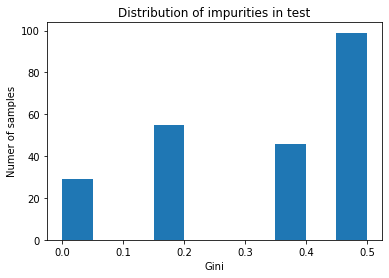

In [48]:
impurities = get_impurity(my_tree, X_test)

plt.hist(impurities);
plt.title('Distribution of impurities in test')
plt.xlabel('Gini')
plt.ylabel('Numer of samples')

### EXERCISE

Try to increase the max depth of the tree to values higher than "3", and check what the Gini values look like.

## Metrics

In this section, we experiment with some other metrics like AUC, ROC or confusion matrix. Once you have trained (fitted) a decision tree, and you have your training and test sets, you can compute any metric you like. I will leave this points as an exercise to you. 

Hint: Look at [this section of the sklearn](https://scikit-learn.org/stable/modules/model_evaluation.html) to know more about using different metrics.

### EXERCISE

Compute the confusion matrix, the AUX and plot the ROC curve from our classification results.

## Pruning

Another validation on trees is simply to prune the tree at optimal depth, to obtain the maximum score, and better generalization. The value "3" that we've used before is too low, but if don't specify anything, the tree will grow too much.

HINT: Look at [this tutorial on sklearn page](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html) that shows you how to use cost-complexity pruning and cross-validation (alpha) pruning.

### EXERCISE

Determine what is the optimal depth for the tree, using cost complexity pruning (as explained in the tutorial suggested before), and cross validation.

To run the CV pruning, you simply must iterate over different values of `max_depth` and evaluate your fitted tree using `cv_validate()` to later decide what is the value of depth that provides the optimal depth for the tree.

## Bagging and Random Forests

As a final step, we can concentrate on whether the model selected is the best possible option. We can compare our results with a single tree against the option of using Bagging trees or Random Forest. I will also leave this as an exercise to you. You can find all the information you need in my Trees notebook in [github](https://github.com/renero/class_notebooks/blob/master/Tree%20based%20methods.ipynb), or in the [sklearn page](https://scikit-learn.org/stable/modules/ensemble.html).

### EXERCISE

Fit and evaluate models based on Bagging and Random Forests (optional, Boosting trees), and compare the score obtained in test, with the single tree model.